In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [18]:
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.dtypes.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.dtypes.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1.0 - score

In [22]:
from tensorflow.keras.models import load_model
# Register the dice loss function as a custom object in Keras
tf.keras.utils.get_custom_objects().update({'dice_loss': dice_loss})

# Load the saved model
model_dice = load_model('./ENetDice.h5', custom_objects={'dice_loss': dice_loss})

In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the saved model
model_bce = load_model('./ENet.h5')

In [24]:
X = np.load('./X.npy')
Y = np.load('./Y.npy')
import os
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
print("Splitting into training and testing sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

Splitting into training and testing sets...


<Figure size 3000x3000 with 0 Axes>

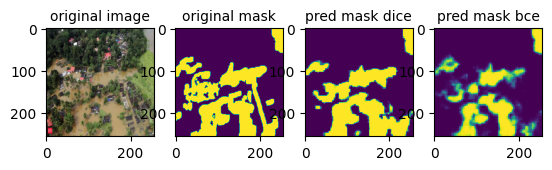

In [38]:
# displaying random image, mask, and predicted mask
import random

plt.figure(figsize=(30,30))

ind = random.randint(0, len(X_test))
img = X_test[ind]
predMask_dice = model_dice.predict(np.expand_dims(img, axis=0), verbose=0)
predMask_bce = model_bce.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(1, 4, 1)
ax1.set_title("original image", fontdict = {'fontsize' : 10})
ax1.imshow(X_test[ind])
ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title("original mask", fontdict = {'fontsize' : 10})
ax2.imshow(np.squeeze(Y_test[ind]))
ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title("pred mask dice", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask_dice))
ax3 = fig.add_subplot(1, 4, 4)
ax3.set_title("pred mask bce", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask_bce))

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

try:
    import medpy
    from medpy.metric.binary import dc
    import cv2
    import plotly.graph_objs as go
except ImportError:
    !pip install medpy
    !pip install opencv-python
    !pip insta  plotly
    import medpy
    from medpy.metric.binary import dc
    import plotly.graph_objs as go
    import cv2

dice_scores_dice = []
iou_scores_dice = []
ap_scores_dice = []

dice_scores_bce = []
iou_scores_bce = []
ap_scores_bce = []

for i in range(len(X_test)):
    img = X_test[i]
    predMask_dice = model_dice.predict(np.expand_dims(img, axis=0), verbose=0)
    predMask_bce = model_bce.predict(np.expand_dims(img, axis=0), verbose=0)

    predMask_dice = np.array(predMask_dice > 0.5, dtype=np.float32)
    predMask_bce = np.array(predMask_bce > 0.5, dtype=np.float32)
    trueMask = Y_test[i]

    # Dice score
    dice_dice = dc(predMask_dice, trueMask)
    dice_scores_dice.append(dice_dice)
    dice_bce = dc(predMask_bce, trueMask)
    dice_scores_bce.append(dice_bce)

    # IoU score
    intersection = np.logical_and(trueMask, predMask_dice)
    union = np.logical_or(trueMask, predMask_dice)
    iou = intersection.sum() / union.sum()
    iou_scores_dice.append(iou)
    intersection = np.logical_and(trueMask, predMask_bce)
    union = np.logical_or(trueMask, predMask_bce)
    iou = intersection.sum() / union.sum()
    iou_scores_bce.append(iou)

    # Average precision score
    ap_dice = average_precision_score(trueMask.ravel(), predMask_dice.ravel())
    ap_scores_dice.append(ap_dice)
    ap_bce = average_precision_score(trueMask.ravel(), predMask_bce.ravel())
    ap_scores_bce.append(ap_bce)

# Compute mean scores
mean_dice_score_dice = np.mean(dice_scores_dice)
mean_iou_score_dice = np.mean(iou_scores_dice)
mean_ap_score_dice = np.mean(ap_scores_dice)

mean_dice_score_bce = np.mean(dice_scores_bce)
mean_iou_score_bce = np.mean(iou_scores_bce)
mean_ap_score_bce = np.mean(ap_scores_bce)

print(f"Dice score (Dice model): {mean_dice_score_dice}")
print(f"IoU score (Dice model): {mean_iou_score_dice}")
print(f"Average Precision score (Dice model): {mean_ap_score_dice}")

print(f"Dice score (BCE model): {mean_dice_score_bce}")
print(f"IoU score (BCE model): {mean_iou_score_bce}")
print(f"Average Precision score (BCE model): {mean_ap_score_bce}")

Dice score (Dice model): 0.8231439207536451
IoU score (Dice model): 0.7246187421634538
Average Precision score (Dice model): 0.7739699402922305
Dice score (BCE model): 0.7979426153689454
IoU score (BCE model): 0.6927334998101661
Average Precision score (BCE model): 0.7685434766830588


In [37]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create traces for each metric and model
dice_trace_dice = go.Bar(
    x=['Dice Score'],
    y=[mean_dice_score_dice],
    name='Model Trained with Dice Loss'
)
dice_trace_bce = go.Bar(
    x=['Dice Score'],
    y=[mean_dice_score_bce],
    name='Model Trained with BCE Loss'
)
iou_trace_dice = go.Bar(
    x=['IoU Score'],
    y=[mean_iou_score_dice],
    name='Model Trained with Dice Loss'
)
iou_trace_bce = go.Bar(
    x=['IoU Score'],
    y=[mean_iou_score_bce],
    name='Model Trained with BCE Loss'
)
ap_trace_dice = go.Bar(
    x=['Average Precision Score'],
    y=[mean_ap_score_dice],
    name='Model Trained with Dice Loss'
)
ap_trace_bce = go.Bar(
    x=['Average Precision Score'],
    y=[mean_ap_score_bce],
    name='Model Trained with BCE Loss'
)

# Create the layout
layout = go.Layout(
    title='Comparison of ENet Models Trained with Dice and BCE Loss Functions',
    yaxis=dict(title='Score'),
    barmode='group'
)

# Create the figure with two subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=('Dice Score', 'IoU Score', 'Average Precision Score', 'Mean Average Precision'))

# Add the traces to the first subplot
fig.add_trace(dice_trace_dice, row=1, col=1)
fig.add_trace(dice_trace_bce, row=1, col=1)
fig.add_trace(iou_trace_dice, row=1, col=2)
fig.add_trace(iou_trace_bce, row=1, col=2)
fig.add_trace(ap_trace_dice, row=2, col=1)
fig.add_trace(ap_trace_bce, row=2, col=1)

# Update the layout and display the figure
fig.update_layout(layout)
fig.show()